#**HOMEWORK: BLUE BIKE TRIP DURATION PREDICTION (Total: / 15 points)**

Context: You have received some data from Blue Bikes (the Boston Bikesharing Service). They have asked you to provide a predictive model that can accurately predict how long a given bike rental will last, at the time the rental begins. The use case is that the bike share company wants to be able to predict how long a customer will have the bike in their possession, when they begin their retnal, in order to better manage operational efficiency across the bike network. Note that when the customer initiates a bike rental, they enter the starting station ID and ending station ID for their trip, into the mobile app.

# *Name: Shu Wang*
# *Email: swang99@bu.edu*

#**Import and Pre-process Data**

## **Import Data** 

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

bluebikes = pd.read_csv('https://raw.githubusercontent.com/gburtch/BA865-2023/main/Lecture%20Materials/C_Assignment/bluebikes_sample.csv')

There are several columns(start station name,end station name,user_type)that are non-numerical features.We need to examine these features first.It is reasonable to extract distance travelled based on the start/end longitude and latitude. 

In [ ]:
print(bluebikes.usertype.unique())
print(bluebikes.gender.unique())


['Subscriber' 'Customer']
[1 2 0]


From the description of usertype and gender,they are categorical variables.I will transform these two variables to binary variable.

In [ ]:
pip install category_encoders


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 3.6 MB/s eta 0:00:00


I will import the haversine package for distance calculation.

In [ ]:
!pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import haversine as hs
from haversine import Unit

## **Preprocess Data** 

###**Analysis on feature selection**

In [ ]:
bluebikes.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1584,09:36.7,36:00.9,442,Hyde Park Ave at Walk Hill St,42.296067,-71.116012,122,Burlington Ave at Brookline Ave,42.345733,-71.100694,4587,Subscriber,1967,1
1,894,40:48.2,55:43.0,80,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,144,Rogers St & Land Blvd,42.365758,-71.076994,2340,Subscriber,1994,1
2,973,58:05.4,14:18.4,57,Columbus Ave at Massachusetts Ave,42.340543,-71.081388,68,Central Square at Mass Ave / Essex St,42.365070,-71.103100,2910,Subscriber,1994,1
3,606,46:45.0,56:51.4,149,175 N Harvard St,42.363796,-71.129164,221,Verizon Innovation Hub 10 Ware Street,42.372509,-71.113054,4526,Subscriber,1992,1
4,428,49:27.9,56:36.7,426,Surface Rd at Summer St,42.352946,-71.056564,420,Charles St at Pinckney St,42.358725,-71.070795,3780,Subscriber,1989,1


In [ ]:
#Check 1-1 correspondence of station id and station name
print(bluebikes.groupby('start station id')["start station name"].nunique().max()==1)
print(bluebikes.groupby('end station id')["end station name"].nunique().max()==1)

True
True


As we can see from above,Station Name has 1-1 correspondence with Station id.the station id,station name variables doesn't add useful information to the model,so we will drop these variables.The start time and end time only records the minute/second/microsecond,with no information on hour.I will transform the start time/end time to seconds within an hour(e.g, 9:36.7 will be transformed into 576.7 seconds).

In [ ]:
# This function MUST return a pair of objects (predictors, labels, in that order) as numpy arrays.
import category_encoders as ce
def processData(data):
    
  ce_OHE = ce.OneHotEncoder(cols=['usertype','gender'])
  #transform the user_type variable to onehot-encoder.
  data = ce_OHE.fit_transform(data)  
  #create two new columns representing the start time and end time within an hour
  data["starttime_inhour"] = ''
  data["endtime_inhour"] = ''
  #create a column calculating distance
  data["distance"] = ''
  len = data.shape[0]
  for i in range(0,len):
   data["starttime_inhour"][i] = int(data["starttime"][i][0:2])*60 + int(data["starttime"][i][3:5]) + float(data["starttime"][i][5:7])
   data["endtime_inhour"][i] = int(data["stoptime"][i][0:2])*60 + int(data["stoptime"][i][3:5]) + float(data["stoptime"][i][5:7])
   data["distance"][i] = hs.haversine((data["start station latitude"][i],data["start station longitude"][i]),(data["end station latitude"][i],data["end station longitude"][i]))
  #drop the original two object columns
  data = data.drop(columns = ["starttime","stoptime"])
  #drop other variables that will not be used in the neural network
  data = data.drop(columns = ["start station name","end station name","start station latitude","end station latitude","start station longitude","end station longitude","start station id","end station id","bikeid"])
  #transform the dataframe into arrays
  arrays = data.values
  train_predictors = arrays[:,1:10]
  train_labels = arrays[:,0]
  #transform the arrays to float type
  train_predictors = np.asarray(train_predictors).astype(np.float32)
  train_labels = np.asarray(train_labels).astype(np.float32)
  return train_predictors, train_labels

#**Building Neural Network Architecture and Processing Sample**

Calling the data pre-processing function on the sample.

In [ ]:
predictors, labels = processData(bluebikes)

<ipython-input-12-8b4ede47dd52>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["starttime_inhour"][i] = int(data["starttime"][i][0:2])*60 + int(data["starttime"][i][3:5]) + float(data["starttime"][i][5:7])
<ipython-input-12-8b4ede47dd52>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["endtime_inhour"][i] = int(data["stoptime"][i][0:2])*60 + int(data["stoptime"][i][3:5]) + float(data["stoptime"][i][5:7])
<ipython-input-12-8b4ede47dd52>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [ ]:
#preview the predictor variable
predictors[0]


array([1.000000e+00, 0.000000e+00, 1.967000e+03, 1.000000e+00,
       0.000000e+00, 0.000000e+00, 5.767000e+02, 2.160900e+03,
       5.664386e+00], dtype=float32)

Specifying my Neural Network's structure. Note that the important thing for performance with this model actually comes down to its depth! It turns out that width isn't that important here. 


## **Build Neural Network Model** 

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Dropout
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization


In [ ]:
def build_model():
    
    model = keras.Sequential(name="Bluebikes-Duration-Model")

    
    model.add(tf.keras.layers.Dense(256, input_shape=(predictors.shape[1],)))
    #add drop out rate
    model.add(Dropout(0.3))
    

    model.add(layers.Dense(128, activation="relu",name="first_hidden"))
    model.add(Dropout(0.3))
    #add normalization
    model.add(BatchNormalization())
    model.add(layers.Dense(64, activation="relu",name="second_hidden"))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    model.add(layers.Dense(32, activation="relu",name="third_hidden"))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(layers.Dense(16, activation="relu",name="fourth_hidden"))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())


    model.add(layers.Dense(1,name="output"))

    
    optimizer = keras.optimizers.RMSprop(learning_rate=1e-3)
    
# Compile the model.
    model.compile(optimizer= optimizer, loss="mse", metrics=["mae"])  
    
    return model

#**Training Neural Network**


##**Training on whole dataset**

We first train the model on whole dataset, then use cross-validation.

In [ ]:
model = build_model()
num_epochs = 100
batch_size = 64
all_mae_histories = [] 
#fit the model into whole dataset
history = model.fit(predictors, labels,epochs=num_epochs, batch_size=batch_size, verbose=1)



Epoch 1/100
141/141 [==============================] - 9s 7ms/step - loss: 2677498.7500 - mae: 849.3536
Epoch 2/100
141/141 [==============================] - 1s 7ms/step - loss: 2674157.0000 - mae: 848.0148
Epoch 3/100
141/141 [==============================] - 1s 7ms/step - loss: 2668172.7500 - mae: 846.0653
Epoch 4/100
141/141 [==============================] - 1s 7ms/step - loss: 2659760.0000 - mae: 843.4628
Epoch 5/100
141/141 [==============================] - 1s 9ms/step - loss: 2650691.2500 - mae: 840.2506
Epoch 6/100
141/141 [==============================] - 1s 9ms/step - loss: 2640594.7500 - mae: 836.4407
Epoch 7/100
141/141 [==============================] - 1s 7ms/step - loss: 2629289.5000 - mae: 831.9937
Epoch 8/100
141/141 [==============================] - 1s 7ms/step - loss: 2616034.0000 - mae: 826.9525
Epoch 9/100
141/141 [==============================] - 1s 7ms/step - loss: 2603610.5000 - mae: 821.3140
Epoch 10/100
141/141 [==============================] - 1s 7ms/s

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'mae'])


In [ ]:
all_mae_histories = []
mae_history = history.history['mae']
all_mae_histories.append(mae_history)
#calculate MAE on the whole dataset
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

###**Model Performance over Training:**

272.9676818847656


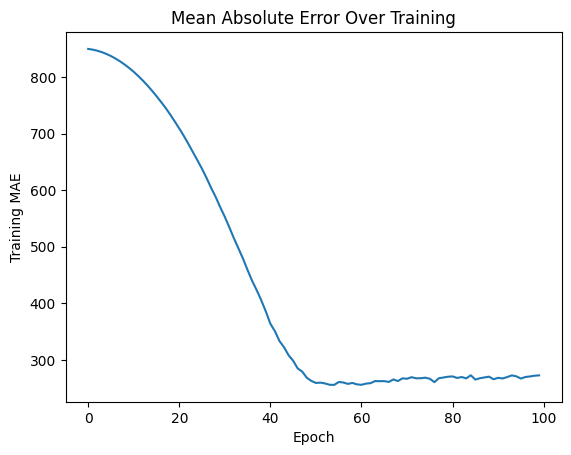

In [ ]:
import matplotlib.pyplot as plt

# Build your plot.
print(average_mae_history[-1])

plt.plot(average_mae_history)
plt.ylabel('Training MAE')
plt.xlabel('Epoch')
plt.title('Mean Absolute Error Over Training')

plt.show()

##**Cross Validation**

###**Model Performance on Cross Validation**

In [ ]:
k = 4 
num_val_samples = len(predictors) // k # floor division (i.e., round down to nearest integer.)
num_epochs = 100
all_val_mae_histories = []  
all_train_histories=[]

print("In total, we have",len(predictors),"training observations.")
print("With a k of",k,"we have",num_val_samples,"observations per fold.\n")

for i in range(k): # the folds are going to be indexed 0 through 3 if k = 4
    print("Processing fold #:",i)
    
    # This is important here, because the last fold won't produce an error, despite our slice going well beyond the end of the array.
    print("Validation data includes observations",i*num_val_samples,"through",(i+1)*num_val_samples-1) # minus 1 because a slice is up to and not including the second index.
    val_data = predictors[i * num_val_samples: (i + 1) * num_val_samples] 
    val_targets = labels[i * num_val_samples: (i + 1) * num_val_samples]
    print("Training data includes observations 0 through",i*num_val_samples-1,"joined with observations",(i+1)*num_val_samples,"through the final observation.\n")
    partial_train_data = np.concatenate(
        [predictors[:i * num_val_samples],
         predictors[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [labels[:i * num_val_samples],
         labels[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=64, verbose=1)
    val_mae_history = history.history['val_mae']
    
    mae_history = history.history['mae']
    all_val_mae_histories.append(val_mae_history)
    all_train_histories.append(mae_history)

In total, we have 9000 training observations.
With a k of 4 we have 2250 observations per fold.

Processing fold #: 0
Validation data includes observations 0 through 2249
Training data includes observations 0 through -1 joined with observations 2250 through the final observation.

Epoch 1/100
106/106 [==============================] - 8s 17ms/step - loss: 3031133.7500 - mae: 854.8290 - val_loss: 1617580.3750 - val_mae: 833.6208
Epoch 2/100
106/106 [==============================] - 1s 12ms/step - loss: 3028658.2500 - mae: 853.9536 - val_loss: 1612869.3750 - val_mae: 832.8726
Epoch 3/100
106/106 [==============================] - 1s 9ms/step - loss: 3024546.2500 - mae: 852.7313 - val_loss: 1614762.5000 - val_mae: 835.3184
Epoch 4/100
106/106 [==============================] - 1s 7ms/step - loss: 3019504.2500 - mae: 851.1476 - val_loss: 1604683.8750 - val_mae: 832.0151
Epoch 5/100
106/106 [==============================] - 1s 9ms/step - loss: 3013441.5000 - mae: 849.2255 - val_loss: 1590

273.5166015625


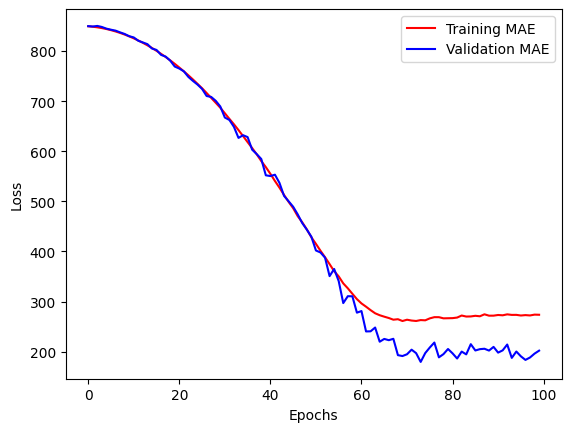

In [ ]:
average_loss_history = [np.mean([x[i] for x in all_train_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_mae_histories]) for i in range(num_epochs)]
print(average_loss_history[-1])
#plot training MAE and validation MAE
plt.plot(average_loss_history,c='r')
plt.plot(average_val_loss_history,c='b')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Training MAE','Validation MAE'])
plt.show()

#**Final Configuration and Model Selection:**

In [ ]:

try:
    from scikeras.wrappers import KerasRegressor                     
except ImportError:
    !pip install scikeras
    from scikeras.wrappers import KerasRegressor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
model = build_model()
model.fit(predictors,labels,epochs=65, batch_size=64,verbose = 1) 

Epoch 1/65
141/141 [==============================] - 4s 7ms/step - loss: 2677467.2500 - mae: 849.4832
Epoch 2/65
141/141 [==============================] - 1s 7ms/step - loss: 2673445.7500 - mae: 848.3104
Epoch 3/65
141/141 [==============================] - 1s 9ms/step - loss: 2668185.7500 - mae: 846.5253
Epoch 4/65
141/141 [==============================] - 1s 9ms/step - loss: 2661146.5000 - mae: 844.1153
Epoch 5/65
141/141 [==============================] - 1s 7ms/step - loss: 2652498.5000 - mae: 841.1038
Epoch 6/65
141/141 [==============================] - 1s 7ms/step - loss: 2642012.7500 - mae: 837.4554
Epoch 7/65
141/141 [==============================] - 1s 7ms/step - loss: 2630958.7500 - mae: 833.2000
Epoch 8/65
141/141 [==============================] - 1s 7ms/step - loss: 2618226.0000 - mae: 828.3313
Epoch 9/65
141/141 [==============================] - 1s 7ms/step - loss: 2604418.0000 - mae: 822.8646
Epoch 10/65
141/141 [==============================] - 1s 6ms/step - loss

Here's what the resulting model looks like.

In [ ]:
model.summary()

Model: "Bluebikes-Duration-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               2560      
                                                                 
 dropout_25 (Dropout)        (None, 256)               0         
                                                                 
 first_hidden (Dense)        (None, 128)               32896     
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_20 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 second_hidden (Dense)       (None, 64)                8256      
                                          

##**Suggestions on Improvements**

The cross-validation shows that the model may suffer underfitting. This may be due to the algorithm of the training& validation sets. The dropout in layers is not executed on validation dataset,(which will prevent overfitting in training). I would suggest using a smaller dropout rate in this case, shuffling the observations to do cross-validation, increase number of hidden layers to increase depth of neural network,decrease complexity of the model.

#**Final Evaluation**

Don't modify this section; this is the code I will use to evaluate that your model is output properly and that it can generate predictions on new test observations it has never seen before. If your model breaks when I feed it the new data, I will deduct marks, so please ensure that your data pre-processing function works properly!

In [ ]:
from google.colab import files
import io

# I'm going to upload my holdout dataset (same set of features)
uploaded = files.upload()
bluebike_holdout = pd.read_csv(io.BytesIO(uploaded['bluebikes_holdout.csv']))

# I'm then going to pre-process it using your commands.
holdout_predictors, holdout_labels = processData(bluebike_holdout)

# Then I'm going to evaluate your model's performance on that data.
loss_metrics = model.evaluate(holdout_predictors,holdout_labels,verbose=1)

Saving bluebikes_holdout.csv to bluebikes_holdout (1).csv


<ipython-input-12-8b4ede47dd52>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["starttime_inhour"][i] = int(data["starttime"][i][0:2])*60 + int(data["starttime"][i][3:5]) + float(data["starttime"][i][5:7])
<ipython-input-12-8b4ede47dd52>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["endtime_inhour"][i] = int(data["stoptime"][i][0:2])*60 + int(data["stoptime"][i][3:5]) + float(data["stoptime"][i][5:7])
<ipython-input-12-8b4ede47dd52>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

64/64 [==============================] - 0s 3ms/step - loss: 30415.4941 - mae: 166.8929
